## Lesson 8 - Artificial Neural Networks 
### Author: Ana Javed

### Wine Classifier


#### Workplace Scenario

Mackenzie has a wine bottling factory and recently attended a followup symposium on deep learning and has returned with fascinating ideas to build neural networks to perform classification tasks. She had the idea of building a red-white wine classifier so that the bottle labels can be automatically generated. She approached your team, and suggested that you build a red-white wine classifier as a modified simple perceptron.

Perform each of the following tasks and answer the related questions:

   - Use the provided RedWhiteWine.csv file. Include ALL the features with “Class” being your output vector
   - Use the provided Simple Perceptron Neural Network notebook to develop a multi-layer feed-forward/backpropagation neural network
   - Be able to adjust the following between experiments:
        - Learning Rate
        - Number of epochs
        - Depth of architecture—number of hidden layers between the input and output layers
        - Number of nodes in a hidden layer—width of the hidden layers
        - (optional) Momentum
   - Determine what the best neural network structure and hyperparameter settings results in the best predictive capability


This code was developed based on the code provided here: https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/


In [25]:
## Importing Necessary Libraries & Packages 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import datetime as dt
import csv
import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Declaring inline visualizations 
%matplotlib inline


## Data Set

We are using the Red, White Wine dataset that can found here: (https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/RedWhiteWine.csv) 

In [26]:
url = "https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/RedWhiteWine.csv"
    
df = pd.read_csv(url, sep=",", header=0)

df.columns =['fixedAcidity','volatileAcidity','citricAcid','residualSugar',
                      'chlorides','freeSulfurDioxide','totalSulfurDioxide','density',
                      'pH','sulphates','alcohol','quality','Class']

In [27]:
## Conducting Exploratory Data Analysis: 

print(df.shape)  # (6497, 13)
print(df.dtypes) 
print(df.describe()) 

df.head()

(6497, 13)
fixedAcidity          float64
volatileAcidity       float64
citricAcid            float64
residualSugar         float64
chlorides             float64
freeSulfurDioxide     float64
totalSulfurDioxide    float64
density               float64
pH                    float64
sulphates             float64
alcohol               float64
quality                 int64
Class                   int64
dtype: object
       fixedAcidity  volatileAcidity   citricAcid  residualSugar    chlorides  \
count   6497.000000      6497.000000  6497.000000    6497.000000  6497.000000   
mean       7.215307         0.339666     0.318633       5.443235     0.056034   
std        1.296434         0.164636     0.145318       4.757804     0.035034   
min        3.800000         0.080000     0.000000       0.600000     0.009000   
25%        6.400000         0.230000     0.250000       1.800000     0.038000   
50%        7.000000         0.290000     0.310000       3.000000     0.047000   
75%        7.70000

,fixedAcidity,volatileAcidity,citricAcid,residualSugar,chlorides,freeSulfurDioxide,totalSulfurDioxide,density,pH,sulphates,alcohol,quality,Class
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [28]:
## Function to Find & Replace Missing values

def replace_missing_values(df):
    for each in df.columns:
        if df.loc[:, each].dtype in ('float64', 'int64'):
            df.loc[:, each] = pd.to_numeric(df.loc[:, each], errors='coerce')
            HasNan1 = np.isnan(df.loc[:, each] )
            
            print("Number of missing values removed in " + each + " column:", sum(HasNan1)) 
            
            if sum(HasNan1) > 0:
                df.loc[HasNan1, each] = np.nanmedian(df.loc[:, each] )
            else:
                continue 



In [29]:
## Missing Value Counts by Columns: 
replace_missing_values(df)

Number of missing values removed in fixedAcidity column: 0
Number of missing values removed in volatileAcidity column: 0
Number of missing values removed in citricAcid column: 0
Number of missing values removed in residualSugar column: 0
Number of missing values removed in chlorides column: 0
Number of missing values removed in freeSulfurDioxide column: 0
Number of missing values removed in totalSulfurDioxide column: 0
Number of missing values removed in density column: 0
Number of missing values removed in pH column: 0
Number of missing values removed in sulphates column: 0
Number of missing values removed in alcohol column: 0
Number of missing values removed in quality column: 0
Number of missing values removed in Class column: 0


There are no missing data values in the dataset. I will continue to prep data for the artificial neural network.

In [30]:
## Separating The Class Column (Target Variable) from the dataset

X = df.loc[:, ['fixedAcidity','volatileAcidity','citricAcid','residualSugar',
                      'chlorides','freeSulfurDioxide','totalSulfurDioxide','density',
                      'pH','sulphates','alcohol','quality']]

Y = df.loc[:, "Class"]


In [31]:
## Normalizing Independent Attributes with StandardScaler 

# print(X.describe())
standardization_scale = StandardScaler().fit(X)
X = pd.DataFrame(standardization_scale.transform(X), 
                             columns=X.columns)

# X.describe()

## Creating a Dataframe of Normalized Independent Columns + Depdendent Class Columns 
X_full = X
X_full["Class"] = Y

## Converting X and Y To Arrays
X = np.transpose(X).to_numpy()
Y = Y.to_numpy()


# X_full.head()

### Initialize Parameters
Because this there are not hidden layers, the second dimension is always assigned to 1. std is set to ${1^{-1}}$ to ensure values are between zero and 1. If zeros, there's no reason to multiply with std.

In [32]:
from random import seed
from random import random
from math import exp

# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs, num_hidden_layers):
    network = list()
    
    count = 0
    
    for i in range(0, num_hidden_layers +1) :
        # print(i)
        hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
        network.append(hidden_layer)
        count += 1 
        
        if num_hidden_layers == count:
            break 
        
    output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    return network

In [33]:
## Testing the Initialize_network function by printing out the layers one by one 

seed(123)
network = initialize_network(2,1,2, num_hidden_layers =1)
for layer in network:
        print(layer)
        
## Hidding layer has one neuron with 2 inputs plus bias 
## The output layer has 2 neurons each with 1 weight plus bias 

[{'weights': [0.052363598850944326, 0.08718667752263232, 0.4072417636703983]}]
[{'weights': [0.10770023493843905, 0.9011988779516946]}, {'weights': [0.0381536661023224, 0.5362020400339269]}]


In [34]:
## Calculate neuron activation for an input
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

## Transfer Neuron Activation
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))

### Forward Propagation
Here, I am assuming a single layered network. Note that event with single layered network, the layer itself can have multiple nodes. Also, I am using vectorized operations here i.e not using explicit loops. This helps in processing multiple inputs.

In [35]:
## Forward Propogation input to a Network Output
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs


### Backpropagation

In [36]:
# Calculate the derivative of an neuron output
def transfer_derivative(output):
    return output * (1.0 - output)

 
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

In [37]:
# Update network weights with error
def update_weights(network, row, l_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += l_rate * neuron['delta']

In [38]:
# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
    errors = list()
    for epoch in range(n_epoch):
        sum_error = 0
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
#             print(expected)
#             print(row)
            expected[int(row[-1])] = 1
            sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
        errors.append(sum_error)
    return errors 

In [39]:
## Converting full data frame to numpy array 
X_full = X_full.to_numpy()


### Running the Experiment (Attempt 1): 
#### 20 Epochs, 2 Hidden Layer Width, Learning Rate = 0.5

In [40]:
## Setting Variables for the Neural Network 
num_epochs = 20   # Number of Epochs
learning_rate = 0.5 # Learning Rate

hidden_layer_width = 2  # Number of Nodes in Hidden Layer
num_hidden_layers = 1   # Number of Hidden Layers between Input and Output layers 

n_inputs = len(X_full[0]) - 1  # Number of Inputs 
n_outputs = len(set([row[-1] for row in X_full])) # Number of Outputs 

network = initialize_network(n_inputs, hidden_layer_width, n_outputs, num_hidden_layers)
errors = train_network(network, X_full, learning_rate, num_epochs, n_outputs)



>epoch=0, lrate=0.500, error=100.999
>epoch=1, lrate=0.500, error=120.641
>epoch=2, lrate=0.500, error=55.455
>epoch=3, lrate=0.500, error=53.011
>epoch=4, lrate=0.500, error=52.151
>epoch=5, lrate=0.500, error=50.118
>epoch=6, lrate=0.500, error=51.735
>epoch=7, lrate=0.500, error=52.375
>epoch=8, lrate=0.500, error=54.308
>epoch=9, lrate=0.500, error=53.329
>epoch=10, lrate=0.500, error=52.973
>epoch=11, lrate=0.500, error=53.840
>epoch=12, lrate=0.500, error=54.509
>epoch=13, lrate=0.500, error=54.620
>epoch=14, lrate=0.500, error=57.037
>epoch=15, lrate=0.500, error=54.837
>epoch=16, lrate=0.500, error=54.588
>epoch=17, lrate=0.500, error=54.775
>epoch=18, lrate=0.500, error=53.297
>epoch=19, lrate=0.500, error=52.364


In [41]:
count = 0
for layer in network:
    if count != num_hidden_layers:
        print("Hidden Layer:")
    elif count == num_hidden_layers:
        print("Output Layer")
        
    print(layer)
    count += 1 
    print("\n")

Hidden Layer:
[{'weights': [-0.167663361158089, -0.01645577275355247, -0.31392321450945393, -1.915654757412831, 4.823979362062677, 1.7178714389217193, -3.666143821759209, 5.568881161833112, -0.5607113909693742, 0.6434395188391566, 2.4131966577472594, 1.9585880094586885, -4.015345518527125], 'output': 4.71726607430482e-07, 'delta': -5.438412375372857e-14}, {'weights': [-0.16967975243227254, -1.788383489314633, 0.41251731372311035, 3.2671413695699996, 0.2576728904079014, -0.47368763495162575, 2.935484836548079, -3.9609076092084186, -0.31437197130913463, -0.23066634886108975, -1.1943808791529336, 0.0318690577389258, 2.0601089148565848], 'output': 0.9962438656467743, 'delta': 5.113521047131355e-10}]


Output Layer
[{'weights': [-5.826813850841552, 6.903709577343292, 2.3403257370218093], 'output': 0.9999007829335036, 'delta': 9.843049588741481e-09}, {'weights': [5.820429441890063, -6.901832080464204, -2.3366145417792605], 'output': 9.977235316405107e-05, 'delta': -9.953529269762083e-09}]




### Errors Plot: 20 Epochs, 0.5 Learning Rate, 2 Hidden Layer Widths

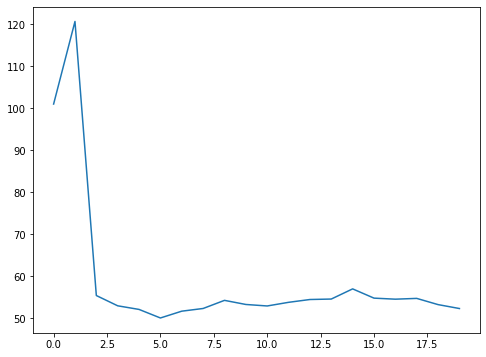

In [42]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 6.0) #Set default plot sizes
plt.rcParams['image.interpolation'] = 'nearest' #Use nearest neighbor for rendering

plt.plot(errors)

### Running the Experiment  (Attempt 2): 
#### 50 Epochs, 3 Hidden Layer Width, Learning Rate = 0.25

In [43]:
## Setting Variables for the Neural Network 
num_epochs = 50   # Number of Epochs
learning_rate = 0.25 # Learning Rate

hidden_layer_width = 3  # Number of Nodes in Hidden Layer
num_hidden_layers = 1   # Number of Hidden Layers between Input and Output layers 

n_inputs = len(X_full[0]) - 1  # Number of Inputs 
n_outputs = len(set([row[-1] for row in X_full])) # Number of Outputs 

network = initialize_network(n_inputs, hidden_layer_width, n_outputs, num_hidden_layers)
errors = train_network(network, X_full, learning_rate, num_epochs, n_outputs)



>epoch=0, lrate=0.250, error=170.894
>epoch=1, lrate=0.250, error=278.199
>epoch=2, lrate=0.250, error=71.606
>epoch=3, lrate=0.250, error=60.903
>epoch=4, lrate=0.250, error=58.685
>epoch=5, lrate=0.250, error=57.043
>epoch=6, lrate=0.250, error=55.734
>epoch=7, lrate=0.250, error=54.590
>epoch=8, lrate=0.250, error=53.360
>epoch=9, lrate=0.250, error=51.902
>epoch=10, lrate=0.250, error=50.425
>epoch=11, lrate=0.250, error=48.970
>epoch=12, lrate=0.250, error=47.356
>epoch=13, lrate=0.250, error=45.871
>epoch=14, lrate=0.250, error=44.957
>epoch=15, lrate=0.250, error=44.142
>epoch=16, lrate=0.250, error=43.401
>epoch=17, lrate=0.250, error=42.810
>epoch=18, lrate=0.250, error=42.320
>epoch=19, lrate=0.250, error=41.943
>epoch=20, lrate=0.250, error=41.619
>epoch=21, lrate=0.250, error=41.349
>epoch=22, lrate=0.250, error=41.096
>epoch=23, lrate=0.250, error=40.866
>epoch=24, lrate=0.250, error=40.641
>epoch=25, lrate=0.250, error=40.428
>epoch=26, lrate=0.250, error=40.217
>epoch=27

In [44]:
count = 0
for layer in network:
    if count != num_hidden_layers:
        print("Hidden Layer:")
    elif count == num_hidden_layers:
        print("Output Layer")
        
    print(layer)
    count += 1 
    print("\n")

Hidden Layer:
[{'weights': [-0.6743674217937082, -0.4162539451092365, -0.025680920286451428, 2.636027114645107, -0.17728922864750218, -0.2461250604777693, 1.6849097412069798, -4.20513367005539, -2.2566183068518857, -0.6749996033414705, 0.15332416239004576, -1.6209305617457663, 1.133784357452877], 'output': 0.9989962447044979, 'delta': 5.614563592543611e-13}, {'weights': [-1.5448511941582945, 0.3831666395074542, 0.4595559017372913, -2.251970823161706, 4.640077050401497, 2.3432910413586434, -3.627199792471653, 4.309606934078395, -1.318243858860932, -0.29308741308853514, 2.8031043623987477, -0.06004776852961036, -1.5739364522493684], 'output': 0.0007058504939253826, 'delta': -4.190914098156918e-13}, {'weights': [0.6934298347417294, -1.6893634780001396, 0.6065863343579023, 2.3228853037225687, 0.4679398026951911, -0.9492591645072875, 2.7774013141942744, -1.5861001140783608, 0.7389181924202055, -0.6850767499252052, -0.8469564809529062, 0.9764731812501363, 0.7373933967578831], 'output': 0.851

### Errors Plot: 50 Epochs, .25 Learning Rate, 3 Hidden Layer Widths

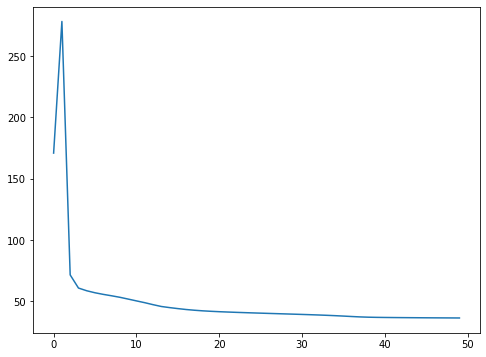

In [45]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 6.0) #Set default plot sizes
plt.rcParams['image.interpolation'] = 'nearest' #Use nearest neighbor for rendering

plt.plot(errors)

### Running the Experiment (Attempt 3): 
#### 20 Epochs, 4 Hidden Layer Width, Learning Rate = 0.25


In [46]:
## Setting Variables for the Neural Network 
num_epochs = 20   # Number of Epochs
learning_rate = 0.25 # Learning Rate

hidden_layer_width = 4  # Number of Nodes in Hidden Layer
num_hidden_layers = 1   # Number of Hidden Layers between Input and Output layers 

n_inputs = len(X_full[0]) - 1  # Number of Inputs 
n_outputs = len(set([row[-1] for row in X_full])) # Number of Outputs 

network = initialize_network(n_inputs, hidden_layer_width, n_outputs, num_hidden_layers)
errors = train_network(network, X_full, learning_rate, num_epochs, n_outputs)



>epoch=0, lrate=0.250, error=146.434
>epoch=1, lrate=0.250, error=157.173
>epoch=2, lrate=0.250, error=67.610
>epoch=3, lrate=0.250, error=59.545
>epoch=4, lrate=0.250, error=56.336
>epoch=5, lrate=0.250, error=54.291
>epoch=6, lrate=0.250, error=52.950
>epoch=7, lrate=0.250, error=51.959
>epoch=8, lrate=0.250, error=50.384
>epoch=9, lrate=0.250, error=49.137
>epoch=10, lrate=0.250, error=47.764
>epoch=11, lrate=0.250, error=46.408
>epoch=12, lrate=0.250, error=45.179
>epoch=13, lrate=0.250, error=44.153
>epoch=14, lrate=0.250, error=43.454
>epoch=15, lrate=0.250, error=42.876
>epoch=16, lrate=0.250, error=42.478
>epoch=17, lrate=0.250, error=42.064
>epoch=18, lrate=0.250, error=41.785
>epoch=19, lrate=0.250, error=41.444


In [47]:
count = 0
for layer in network:
    if count != num_hidden_layers:
        print("Hidden Layer:")
    elif count == num_hidden_layers:
        print("Output Layer")
        
    print(layer)
    count += 1 
    print("\n")

Hidden Layer:
[{'weights': [0.3911644875377161, 1.638314393826468, 0.11373413781459848, -0.7984602604614628, -0.18785981367508384, 0.487878811323241, -1.784814802337942, 2.4603604873097833, -0.4301999575176064, 0.11953011990574482, 1.32385644547273, 0.20213589265288087, -0.9099213671941779], 'output': 0.012805871822429373, 'delta': -1.1573765822417722e-09}, {'weights': [0.2606648164819715, -1.0440320319956253, 0.7488158534483248, 1.3291049370741497, 0.4106186378872889, 0.12614148977413203, 1.7264922553904913, -0.9365966083380077, 0.2357409762157872, -0.24532425129813448, -0.15654981391931344, 0.9013584662121946, 0.6782862565865414], 'output': 0.7902677132777653, 'delta': 1.6132502444904737e-08}, {'weights': [-0.5507411886129233, -0.06681908165376639, 0.10638696763821999, 2.385925299699542, -0.07489877202124247, -0.7508232815934027, 1.6342254340083024, -1.9010835874998866, -1.7958811297640733, -0.874160525751478, 0.41436568902056314, -0.7613493993205033, 1.4267790928416835], 'output': 0

### Errors Plot: 20 Epochs, .25 Learning Rate, 4 Hidden Layer Widths

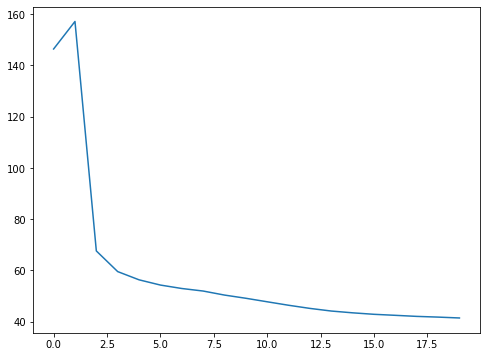

In [48]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 6.0) #Set default plot sizes
plt.rcParams['image.interpolation'] = 'nearest' #Use nearest neighbor for rendering

plt.plot(errors)

## Summary

Determine what the best neural network structure and hyperparameter settings results in the best predictive capability

The three different neural networks that were tested were:
- <b> Attempt 1: </b> Neural Network with 20 Epochs, 0.5 Learning Rate, 2 Hidden Layers
- <b> Attempt 2: </b> Neural Network with 50 Epochs, .25 Learning Rate, 3 Hidden Layers
- <b> Attempt 3: </b> Neural Network with 20 Epochs, .25 Learning Rate, 4 Hidden Layers 

The neural network structure that performed the best out of the three attempts was the second attempt Neural Network. While all three neural networks produced error plots that decreased with each epoch, the first attempt Neural Network brought the error down to 52.364, the third attempt neural network brought it down lower to 40.523, however the second neural network brought the error to the lowest of the three attemps at 36.501. 

It should be noted that while the second attempt produced the lowest error rate at the end, the second attempt neural network also took the longest to run. Since the epoch value was doubled, it was more computationally expensive. If resources are limited when running the neural networks, then the next best option would be the attempt 2 neural network. 
